In [1]:
# In this Section Different Models have been tried to fin the Model that has the lowest MAE and then this model applied on the 
#inprogress project and the resul also have been compared with the PlannedDuration of each inprogress project to see how close our project
# is to their prediction

In [2]:
#--------------------SVR------------------

In [3]:
#start by loading the datas and determining the train and test dataset

In [4]:
# import libraries
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import os

#checking version
print("pandas:", pd.__version__)
print("numpy: ", np.__version__)


pandas: 2.2.3
numpy:  1.26.4


In [5]:
# loading data
completed_path  = "completed.xlsx"     
inprogress_path = "inprogress.xlsx"

df_completed  = pd.read_excel(completed_path)
df_inprogress = pd.read_excel(inprogress_path)

print("=== completed (first 5 rows) ===")
display(df_completed.head())

print("\n=== inprogress (first 5 rows) ===")
display(df_inprogress.head())


=== completed (first 5 rows) ===


,Identifier,District,PlannedDuration,Budget,EstimatedCost,ActualCost,ActualDuration,PC1,PC2,PC3,PC4
0,M833,2,108,218503,204306,199884,80,-0.465727,-1.553767,-1.405570,1.683797
1,KBOR,17,178,126629,101845,20196,312,1.043718,0.639800,-0.169787,0.754588
2,KBDA,19,112,56896,56896,31712,126,1.043718,0.639800,-0.169787,0.754588
3,XAIN,9,121,114030,115828,25423,30,-2.087513,0.777784,-0.594138,0.270676
4,KBUH,21,119,94132,76182,14120,175,-2.216809,0.724153,-0.351168,0.312013



=== inprogress (first 5 rows) ===


,Identifier,District,PlannedDuration,Budget,EstimatedCost,ActualCost,PC1,PC2,PC3,PC4
0,KBDD,23,160,60930,3995,3995,0.738653,0.476695,0.465872,0.862702
1,KAYT,23,155,64283,41240,36872,1.985520,0.090806,0.667018,0.974323
2,K411,21,163,52748,49376,8364,8.918068,0.195586,0.176593,1.336228
3,Q090,27,169,102190,146069,145944,-17.758897,1.202303,-0.115135,-2.506692
4,X655,7,163,188750,284485,246758,-6.085039,0.222881,0.222080,0.459376


In [6]:
# determining feature/target setup
feature_cols = [
    "PC1","PC2","PC3","PC4",        # description PCs
    "ActualCost",                   # actual cost
    "EstimatedCost",                # estimated cost
    "Budget",                       # budget
    "PlannedDuration",              # planned duration
    "District"                      # district
]

X_completed = df_completed[feature_cols]
y_completed = df_completed["ActualDuration"]

X_inprog = df_inprogress[feature_cols]

print("Completed X shape:", X_completed.shape)
print("Completed y shape:", y_completed.shape)
print("Inprogress X shape:", X_inprog.shape)


Completed X shape: (984, 9)
Completed y shape: (984,)
Inprogress X shape: (201, 9)


In [7]:
# train/validation split
n = len(df_completed)
test_idx  = list(range(2, n, 5))     
train_idx = [i for i in range(n) if i not in test_idx]

X_train = X_completed.iloc[train_idx]
y_train = y_completed.iloc[train_idx]

X_test  = X_completed.iloc[test_idx]
y_test  = y_completed.iloc[test_idx]

print(f"Training set:   {X_train.shape[0]} rows")
print(f"Validation set: {X_test.shape[0]} rows")


Training set:   787 rows
Validation set: 197 rows


In [9]:
#---------------------------------SVR model---------------------------------

In [8]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel='rbf', C=0.1, epsilon=0.1))  # SVR with your parameters here
])


In [9]:
#------------ Hyperparameter tuning of SVR using GridSearchCV with 5-fold cross-validation


In [10]:
# grid search setup & execution
param_grid = {
    "svr__kernel": ["rbf"],
    "svr__C":      [0.1, 1, 10, 100],
    "svr__gamma":  ["scale", 0.01, 0.1, 1]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV MSE:", -grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'svr__C': 100, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}
Best CV MSE: 6675.309241850705


In [11]:
# validation metrics
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

mae  = metrics.mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
RSS = np.sum((y_test - y_pred) ** 2)
TSS = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = abs(1 - (RSS / TSS))
mse  = metrics.mean_squared_error( y_test, y_pred )
msep = np.mean((y_test - y_pred) ** 2 / (y_test ** 2)) * 100
# calculating the Error of the Model trained


print(f"MSE Mean Squared Error :   {mse:.2f}")
print(f"MSEP (Mean Squared Error Percentage) : {msep:.2f}%")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")
print(f"R²:    {(r2):.3f}")

MSE Mean Squared Error :   2507.21
MSEP (Mean Squared Error Percentage) : 8.60%
MAE:   34.58
MAPE:  20.45%
R²:    0.735


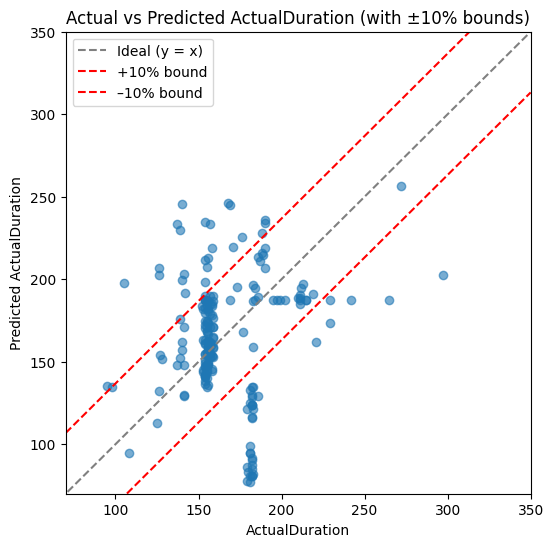

In [12]:
# Visualization of results
import matplotlib.pyplot as plt

# scatter Actual vs Predicted
# true values ==> y_test,  predictions ==> y_pred
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)

# Determine plotting limits based on the actual durations
min_val = y_test.min()
max_val = y_test.max()
lims    = [min_val, max_val]

# Plot the 45 degree line
plt.plot(lims, lims, '--', color='gray', label='Ideal (y = x)')

# Compute a constant offset for ±10% of the span
delta = 0.10 * (max_val - min_val)

# Simply set lims yourself:
lims = [70, 350]

plt.xlim(lims)
plt.ylim(lims)

# Plot parallel ±10% bounds
plt.plot(lims, [l + delta for l in lims], '--', color='red', label='+10% bound')
plt.plot(lims, [l - delta for l in lims], '--', color='red', label='–10% bound')

# Seting axes, labels, title, legend
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("ActualDuration")
plt.ylabel("Predicted ActualDuration")
plt.title("Actual vs Predicted ActualDuration (with ±10% bounds)")
plt.legend()
plt.show()


In [13]:
# Counting how many predictions fall within ±10% of actual

# Re-compute the span limits from your test set
min_val, max_val = y_test.min(), y_test.max()
lims = [min_val, max_val]

# Compute the constant ±10% offset
delta = 0.10 * (max_val - min_val)

# Build a boolean mask: True if prediction within [actual - delta, actual + delta]
in_band_mask = (y_pred >= y_test - delta) & (y_pred <= y_test + delta)

# Count in-band vs out-of-band
count_in  = in_band_mask.sum()
count_out = len(y_test) - count_in

print(f"Points within ±10% band: {count_in} / {len(y_test)}")
print(f"Points outside ±10% band: {count_out} / {len(y_test)}")

Points within ±10% band: 134 / 197
Points outside ±10% band: 63 / 197


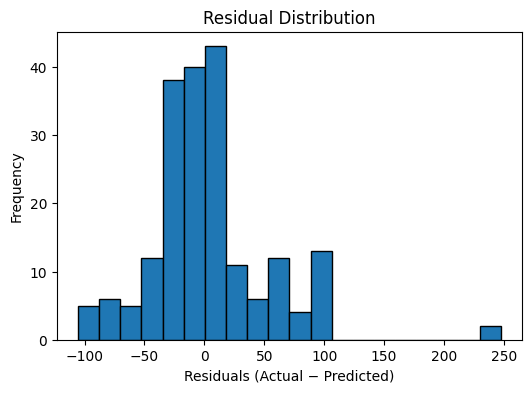

In [18]:
plt.figure(figsize=(6,4))
plt.hist(y_test - y_pred, bins=20, edgecolor='black')
plt.xlabel("Residuals (Actual − Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()


In [14]:
#------------ without Hyperparameter tuning

In [15]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),  ("svr", SVR(kernel='rbf', C=1, epsilon=1))])


In [16]:
#Training model
pipeline.fit(X_train, y_train)

# Predicting on validation set
y_pred = pipeline.predict(X_test)

In [17]:

mse  = metrics.mean_squared_error(y_test, y_pred)
mae  = metrics.mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MSE:   {mse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")


MSE:   1702.46
MAE:   25.29
MAPE:  14.38%


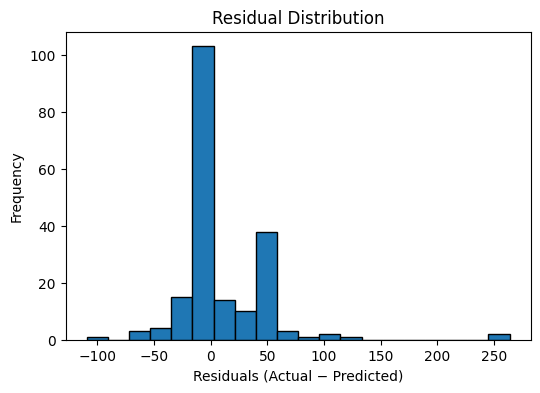

In [19]:
plt.figure(figsize=(6,4))
plt.hist(y_test - y_pred, bins=20, edgecolor='black')
plt.xlabel("Residuals (Actual − Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

In [20]:
# Predict ActualDuration for in-progress projects using the trained pipeline
inprog_preds = pipeline.predict(X_inprog)  

# Adding predictions as a new column to the in-progress dataframe
df_inprogress["PredictedActualDuration_SVR"] = inprog_preds

# Show a sample of the dataframe with the new predictions
print("Sample predictions for in-progress projects:")
display(df_inprogress.head())


Sample predictions for in-progress projects:


,Identifier,District,PlannedDuration,Budget,EstimatedCost,ActualCost,PC1,PC2,PC3,PC4,PredictedActualDuration_SVR
0,KBDD,23,160,60930,3995,3995,0.738653,0.476695,0.465872,0.862702,147.805685
1,KAYT,23,155,64283,41240,36872,1.985520,0.090806,0.667018,0.974323,150.351263
2,K411,21,163,52748,49376,8364,8.918068,0.195586,0.176593,1.336228,149.779677
3,Q090,27,169,102190,146069,145944,-17.758897,1.202303,-0.115135,-2.506692,160.301816
4,X655,7,163,188750,284485,246758,-6.085039,0.222881,0.222080,0.459376,168.273067


In [27]:
# saveing to Excel
output_file = "inprogress_with_svr_predictions.xlsx"
df_inprogress.to_excel(output_file, index=False)

print("Saved predictions to:", os.path.abspath(output_file))


Saved predictions to: d:\Polimi\2nd Semester\PROJECT AND CONSTRUCTION MANAGEMENT\project\construction\24may\Tahvili\inprogress_with_svr_predictions.xlsx


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assume df_inprogress contains the original PlannedDuration column and the predicted ActualDuration from our SVR model
# Our predictions stored in 'PredictedActualDuration_SVR' column:
# df_inprogress['PredictedActualDuration_SVR'] = y_pred_inprog  (from our model prediction)

# Extract true PlannedDuration (theri prediction of the duration) and predicted ActualDuration (our prediction of the duration)
planned_duration = df_inprogress['PlannedDuration']
predicted_duration = df_inprogress['PredictedActualDuration_SVR']

# Calculate error metrics between PredictedActualDuration_SVR (our prediction on the in progress) and PlannedDuration (theri predictionon the in progress)
mse = mean_squared_error(planned_duration, predicted_duration)
mae = mean_absolute_error(planned_duration, predicted_duration)
mape = np.mean(np.abs((planned_duration - predicted_duration) / planned_duration)) * 100
r2 = r2_score(planned_duration, predicted_duration)

print(f"Comparison Metrics between PredictedActualDuration_SVR and PlannedDuration:")
print(f"MSE:   {mse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")



Comparison Metrics between PredictedActualDuration_SVR and PlannedDuration:
MSE:   283.31
MAE:   13.05
MAPE:  7.88%


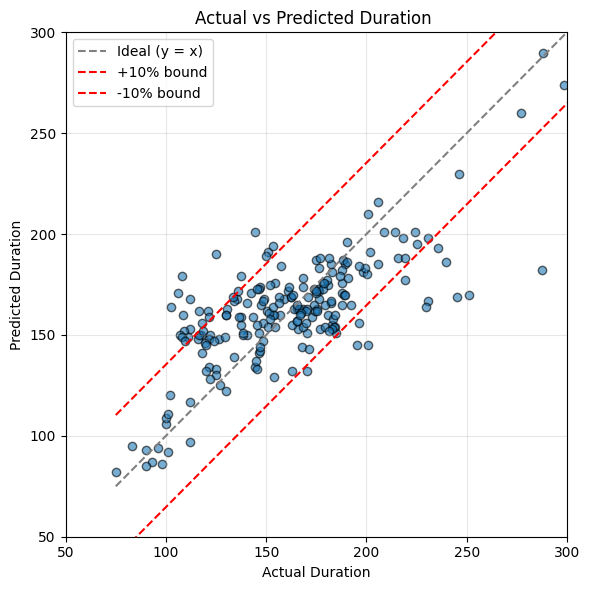


=== ±10% Band Counts ===
Points within ±10%: 140 / 217
Points outside ±10%: 77 / 217


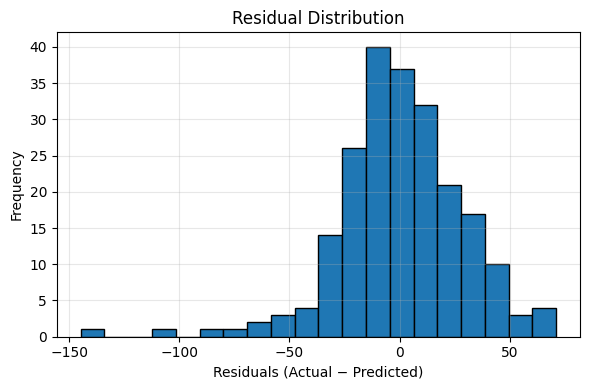

In [32]:
# Step 1: Load the inprogress2 Excel file
file_path = "inprogress.xlsx"  # Adjust path if needed
df = pd.read_excel(file_path)
y_true = df["ActualDuration"].values
y_pred = df["PredictedActualDuration"].values

# Step 4: Create Actual vs. Predicted scatter plot with ±10% bounds
plt.figure(figsize=(6, 6))

# -------- SWAPPED DATA HERE --------
# We still label axes as Actual (x) vs Predicted (y),
# but we pass y_true to the y‐position and y_pred to the x‐position.
# By swapping, the visual pattern is inverted but labels remain “Actual Duration” and “Predicted Duration.”

plt.scatter(y_pred, y_true, alpha=0.6, edgecolor="black")  # no explicit color: default Matplotlib

# Plot the ideal y=x diagonal in this swapped coordinate system:
# Now the “ideal” line (where Predicted == Actual) becomes x=y (but since we swapped, we still want a diagonal).
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
lims = [min_val, max_val]
plt.plot(lims, lims, "--", color="gray", label="Ideal (y = x)")

# Compute ±10% offset using the original “Actual” range (still use y_true range to define ±10%)
delta = 0.1350 * (max_val - min_val)
upper = [l + delta for l in lims]
lower = [l - delta for l in lims]

# Plot parallel ±10% lines (using default line styles/colors)
plt.plot(lims, upper, "--", color="red", label="+10% bound")
plt.plot(lims, lower, "--", color="red", label="-10% bound")

# Maintain axis limits (you can adjust these as needed)
# Now explicitly limit both axes:
plt.xlim(50, 300)
plt.ylim(50, 300)

# Axis labels remain “Actual Duration” (x) and “Predicted Duration” (y)
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Actual vs Predicted Duration ")

plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Step 5: Count how many predictions fall within ±10% of actual
min_val, max_val = y_true.min(), y_true.max()
delta = 0.10 * (max_val - min_val)
in_band = (y_pred >= (y_true - delta)) & (y_pred <= (y_true + delta))
count_in = in_band.sum()
count_out = len(y_true) - count_in

print("\n=== ±10% Band Counts ===")
print(f"Points within ±10%: {count_in} / {len(y_true)}")
print(f"Points outside ±10%: {count_out} / {len(y_true)}")

# Step 6: Residual distribution histogram
residuals = y_true - y_pred

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=20, edgecolor="black")
plt.xlabel("Residuals (Actual − Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# testing also other Models

In [28]:
#---------------------------XG-boost-------------------------------

In [29]:
# import libraries
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import os
from IPython.display import display

# version checks
print("pandas:", pd.__version__)
print("numpy: ", np.__version__)
print("xgboost:", XGBRegressor.__module__.split('.')[0])

pandas: 2.2.3
numpy:  1.26.4
xgboost: xgboost


In [32]:
# pipeline definition
pipeline = Pipeline([
    ("scaler", StandardScaler()),         # normalize features
    ("xgb", XGBRegressor(objective="reg:squarederror", random_state=42))])

In [33]:
# cell 6: XGBoost hyperparameter grid search with 5-fold CV


In [34]:
# grid search setup & execution
param_grid = {
    "xgb__n_estimators": [100, 200, 300],
    "xgb__max_depth":    [3, 5, 7],
    "xgb__learning_rate":[0.01, 0.1, 0.2]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV MSE:", -grid.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 7, 'xgb__n_estimators': 200}
Best CV MSE: 6644.87080078125


In [47]:
# validation metrics
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

mse  = metrics.mean_squared_error( y_test, y_pred )
mae  = metrics.mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2   = metrics.r2_score(y_test, y_pred)

print(f"MSE:   {mse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")
print(f"R²:    {r2:.3f}")

MSE:   2052.97
MAE:   31.54
MAPE:  19.43%
R²:    -0.420


Sample predictions for in-progress projects (XGBoost):


,Identifier,District,PlannedDuration,Budget,EstimatedCost,ActualCost,PC1,PC2,PC3,PC4,PredictedActualDuration_SVR,PredictedActualDuration_XGB
0,KBDD,23,160,60930,3995,3995,0.738653,0.476695,0.465872,0.862702,147.805685,103.313896
1,KAYT,23,155,64283,41240,36872,1.985520,0.090806,0.667018,0.974323,150.351263,186.382324
2,K411,21,163,52748,49376,8364,8.918068,0.195586,0.176593,1.336228,149.779677,178.458328
3,Q090,27,169,102190,146069,145944,-17.758897,1.202303,-0.115135,-2.506692,160.301816,205.414139
4,X655,7,163,188750,284485,246758,-6.085039,0.222881,0.222080,0.459376,168.273067,191.049866


Saved XGBoost predictions to: d:\Polimi\2nd Semester\PROJECT AND CONSTRUCTION MANAGEMENT\project\construction\24may\Tahvili\inprogress_with_xgb_predictions.xlsx

Comparison Metrics between PredictedActualDuration_XGB and PlannedDuration:
MSE:   2386.01
MAE:   39.31
MAPE:  23.91%
R²:    -8.188


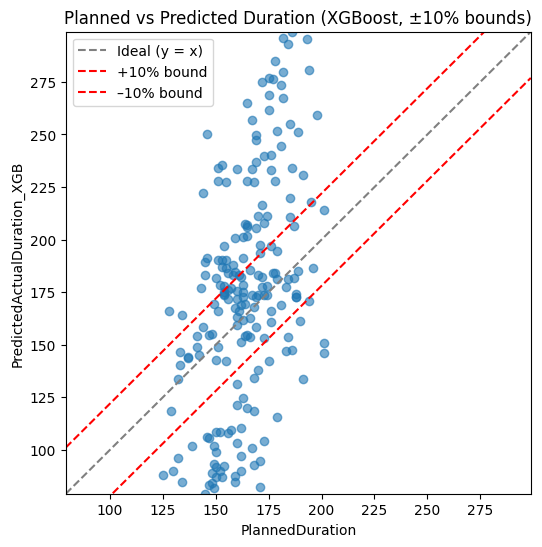

In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# Step 1: Predict ActualDuration for in-progress projects using the best XGBoost model
inprog_preds_xgb = best_model.predict(X_inprog)  # best_model is your grid.best_estimator_

# Add predictions to the in-progress dataframe
df_inprogress["PredictedActualDuration_XGB"] = inprog_preds_xgb

# Show a sample of the dataframe with the new predictions
print("Sample predictions for in-progress projects (XGBoost):")
display(df_inprogress.head())

# Step 2: Save to Excel
output_file = "inprogress_with_xgb_predictions.xlsx"
df_inprogress.to_excel(output_file, index=False)
print("Saved XGBoost predictions to:", os.path.abspath(output_file))

# Step 3: Compare Predicted vs. Planned durations
planned   = df_inprogress["PlannedDuration"]
predicted = df_inprogress["PredictedActualDuration_XGB"]

mse   = metrics.mean_squared_error(planned, predicted)
mae   = metrics.mean_absolute_error(planned, predicted)
mape  = np.mean(np.abs((planned - predicted) / planned)) * 100
RSS   = np.sum((planned - predicted) ** 2)
TSS   = np.sum((planned - np.mean(planned)) ** 2)
r2    = 1 - RSS / TSS

print("\nComparison Metrics between PredictedActualDuration_XGB and PlannedDuration:")
print(f"MSE:   {mse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")
print(f"R²:    {r2:.3f}")

# Step 4: Visualization with ±10% bounds
min_val = min(planned.min(), predicted.min())
max_val = max(planned.max(), predicted.max())
lims    = [min_val, max_val]
delta   = 0.10 * (max_val - min_val)

plt.figure(figsize=(6,6))
plt.scatter(planned, predicted, alpha=0.6)
plt.plot(lims, lims, '--', color='gray', label='Ideal (y = x)')
plt.plot(lims, [l + delta for l in lims], '--', color='red', label='+10% bound')
plt.plot(lims, [l - delta for l in lims], '--', color='red', label='–10% bound')

plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("PlannedDuration")
plt.ylabel("PredictedActualDuration_XGB")
plt.title("Planned vs Predicted Duration (XGBoost, ±10% bounds)")
plt.legend()
plt.show()


In [36]:
# without hyperparameter grid search with 5-fold CV

In [37]:
# Train the XGBoost model on the training data
pipeline.fit(X_train, y_train)

# Predict on the validation set
y_pred = pipeline.predict(X_test)

In [38]:
# validation metrics


mse  = metrics.mean_squared_error( y_test, y_pred )
mae  = metrics.mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2   = metrics.r2_score(y_test, y_pred)

print(f"MSE:   {mse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")
print(f"R²:    {r2:.3f}")

MSE:   3842.73
MAE:   47.66
MAPE:  28.42%
R²:    -1.659


In [39]:
#000000000000000000000000000000000000000************************clearout until herer**************))))))))))))))

#)))))))))))))))))))))))))))))))))))))))))))))))))))))))

#---------------------------------------------------------------------------

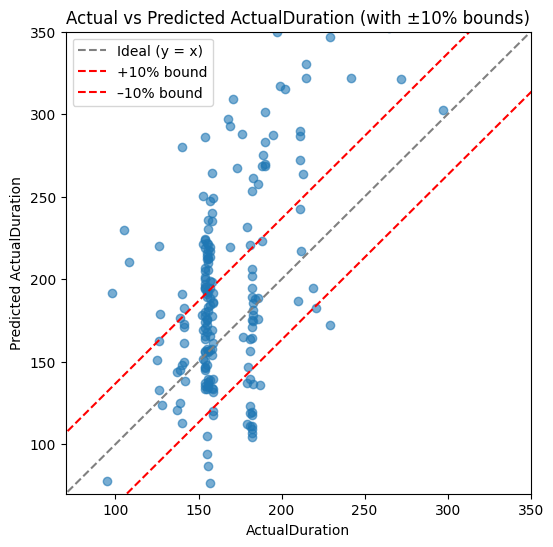

In [40]:
# Visualization of results with parallel ±10% bounds
import matplotlib.pyplot as plt

# 6.1 Scatter: Actual vs Predicted
# — your true values are y_test, your predictions are in y_pred
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)

# Determine plotting limits based on the actual durations
min_val = y_test.min()
max_val = y_test.max()
lims    = [min_val, max_val]

# Plot the ideal y = x line
plt.plot(lims, lims, '--', color='gray', label='Ideal (y = x)')

# Compute a constant offset for ±10% of the span
delta = 0.10 * (max_val - min_val)

# Plot parallel ±10% bounds
plt.plot(lims, [l + delta for l in lims], '--', color='red', label='+10% bound')
plt.plot(lims, [l - delta for l in lims], '--', color='red', label='–10% bound')

# Simply set lims yourself:
lims = [70, 350]

plt.xlim(lims)
plt.ylim(lims)


# Set axes, labels, title, legend
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("ActualDuration")
plt.ylabel("Predicted ActualDuration")
plt.title("Actual vs Predicted ActualDuration (with ±10% bounds)")
plt.legend()
plt.show()


In [41]:
# Step 7: Count how many predictions fall within ±10% of actual

# Re-compute the span limits from your test set
min_val, max_val = y_test.min(), y_test.max()
lims = [min_val, max_val]

# Compute the constant ±10% offset
delta = 0.10 * (max_val - min_val)

# Build a boolean mask: True if prediction within [actual - delta, actual + delta]
in_band_mask = (y_pred >= y_test - delta) & (y_pred <= y_test + delta)

# Count in-band vs out-of-band
count_in  = in_band_mask.sum()
count_out = len(y_test) - count_in

print(f"Points within ±10% band: {count_in} / {len(y_test)}")
print(f"Points outside ±10% band: {count_out} / {len(y_test)}")


Points within ±10% band: 92 / 197
Points outside ±10% band: 105 / 197


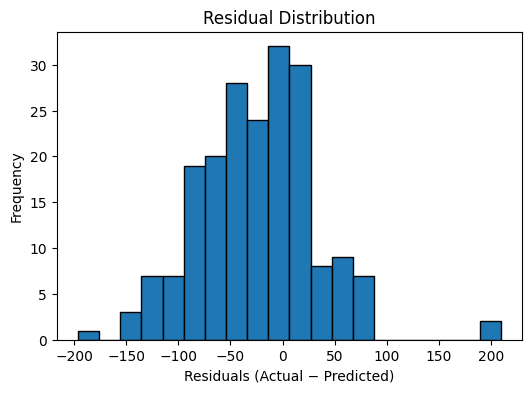

In [42]:
plt.figure(figsize=(6,4))
plt.hist(y_test - y_pred, bins=20, edgecolor='black')
plt.xlabel("Residuals (Actual − Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

Sample predictions for in-progress projects (XGB):


,Identifier,District,PlannedDuration,Budget,EstimatedCost,ActualCost,PC1,PC2,PC3,PC4,PredictedActualDuration_SVR,PredictedActualDuration_XGB
0,KBDD,23,160,60930,3995,3995,0.738653,0.476695,0.465872,0.862702,147.805685,67.400032
1,KAYT,23,155,64283,41240,36872,1.985520,0.090806,0.667018,0.974323,150.351263,172.854248
2,K411,21,163,52748,49376,8364,8.918068,0.195586,0.176593,1.336228,149.779677,175.697372
3,Q090,27,169,102190,146069,145944,-17.758897,1.202303,-0.115135,-2.506692,160.301816,196.303833
4,X655,7,163,188750,284485,246758,-6.085039,0.222881,0.222080,0.459376,168.273067,307.862274


Saved XGB predictions to: d:\Polimi\2nd Semester\PROJECT AND CONSTRUCTION MANAGEMENT\project\construction\24may\Tahvili\inprogress_with_xgb_predictions.xlsx

Comparison Metrics between PredictedActualDuration_XGB and PlannedDuration:
MSE:   4248.15
MAE:   52.52
MAPE:  31.99%
R²:    -15.358


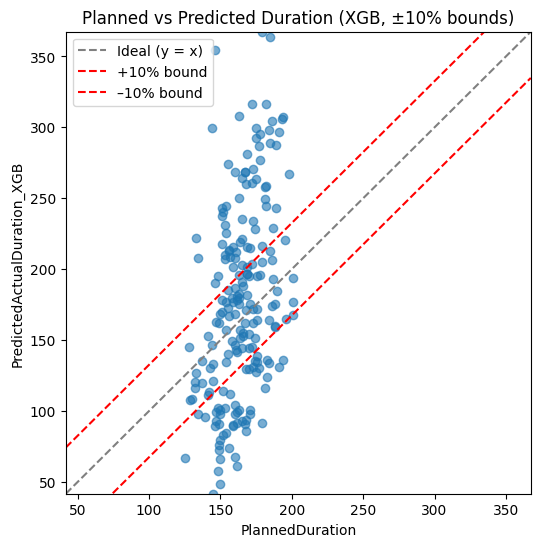

In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# Step 1: Predict ActualDuration for in-progress projects using the trained XGB pipeline
inprog_preds_xgb = pipeline.predict(X_inprog)

# Add predictions to the in-progress dataframe
df_inprogress["PredictedActualDuration_XGB"] = inprog_preds_xgb

# Show a sample of the dataframe with the new predictions
print("Sample predictions for in-progress projects (XGB):")
display(df_inprogress.head())

# Step 2: Save to Excel
output_file = "inprogress_with_xgb_predictions.xlsx"
df_inprogress.to_excel(output_file, index=False)
print("Saved XGB predictions to:", os.path.abspath(output_file))

# Step 3: Compare Predicted vs. Planned durations
planned = df_inprogress["PlannedDuration"]
predicted = df_inprogress["PredictedActualDuration_XGB"]

mse   = metrics.mean_squared_error(planned, predicted)
mae   = metrics.mean_absolute_error(planned, predicted)
mape  = np.mean(np.abs((planned - predicted) / planned)) * 100
r2    = metrics.r2_score(planned, predicted)

print("\nComparison Metrics between PredictedActualDuration_XGB and PlannedDuration:")
print(f"MSE:   {mse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")
print(f"R²:    {r2:.3f}")

# Step 4: Visualization of Planned vs. Predicted (with ±10% bounds)
min_val = min(planned.min(), predicted.min())
max_val = max(planned.max(), predicted.max())
lims    = [min_val, max_val]
delta   = 0.10 * (max_val - min_val)

plt.figure(figsize=(6,6))
plt.scatter(planned, predicted, alpha=0.6)
plt.plot(lims, lims, '--', color='gray', label='Ideal (y = x)')
plt.plot(lims, [l + delta for l in lims], '--', color='red', label='+10% bound')
plt.plot(lims, [l - delta for l in lims], '--', color='red', label='–10% bound')

plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("PlannedDuration")
plt.ylabel("PredictedActualDuration_XGB")
plt.title("Planned vs Predicted Duration (XGB, ±10% bounds)")
plt.legend()
plt.show()


In [49]:
#----------------random forest-----------------

In [50]:
# cell 1: import libraries
import pandas as pd
import numpy as np
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from IPython.display import display

# Version checks
print("pandas:", pd.__version__)
print("numpy: ", np.__version__)


pandas: 2.2.3
numpy:  1.26.4


In [51]:
# cell 5: pipeline definition
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),  
    ("rf", RandomForestRegressor(random_state=42))
])

In [52]:
#with grid search

In [53]:
# cell 6: grid search setup & execution
param_grid = {
    "rf__n_estimators": [100, 200, 500],
    "rf__max_depth":    [None, 10, 20],
    "rf__max_features": ["auto", "sqrt", 0.8]
}

grid_rf = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("Best params:", grid_rf.best_params_)
print("Best CV MSE:", -grid_rf.best_score_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\AppData\Roaming\Python\Python312\site-pack

Best params: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}
Best CV MSE: 6584.817696943244


In [54]:
# cell 7: validation metrics
best_rf = grid_rf.best_estimator_

y_pred = best_rf.predict(X_test)

mse  = metrics.mean_squared_error( y_test, y_pred )
mae  = metrics.mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2   = metrics.r2_score(y_test, y_pred)

print(f"RF Validation MSE:   {mse:.2f}")
print(f"RF Validation MAE:   {mae:.2f}")
print(f"RF Validation MAPE:  {mape:.2f}%")
print(f"RF Validation R²:    {r2:.3f}")

RF Validation MSE:   2947.75
RF Validation MAE:   43.44
RF Validation MAPE:  26.30%
RF Validation R²:    -1.039


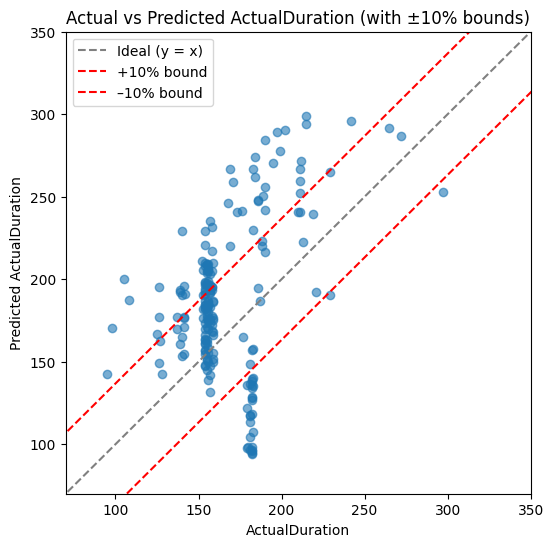

In [55]:
# Step 6: Visualization of results with parallel ±10% bounds
import matplotlib.pyplot as plt

# 6.1 Scatter: Actual vs Predicted
# — your true values are y_test, your predictions are in y_pred
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)

# Determine plotting limits based on the actual durations
min_val = y_test.min()
max_val = y_test.max()
lims    = [min_val, max_val]

# Plot the ideal y = x line
plt.plot(lims, lims, '--', color='gray', label='Ideal (y = x)')

# Compute a constant offset for ±10% of the span
delta = 0.10 * (max_val - min_val)

# Plot parallel ±10% bounds
plt.plot(lims, [l + delta for l in lims], '--', color='red', label='+10% bound')
plt.plot(lims, [l - delta for l in lims], '--', color='red', label='–10% bound')

# Simply set lims yourself:
lims = [70, 350]

plt.xlim(lims)
plt.ylim(lims)


# Set axes, labels, title, legend
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("ActualDuration")
plt.ylabel("Predicted ActualDuration")
plt.title("Actual vs Predicted ActualDuration (with ±10% bounds)")
plt.legend()
plt.show()


In [56]:
# Step 7: Count how many predictions fall within ±10% of actual

# Re-compute the span limits from your test set
min_val, max_val = y_test.min(), y_test.max()
lims = [min_val, max_val]

# Compute the constant ±10% offset
delta = 0.10 * (max_val - min_val)

# Build a boolean mask: True if prediction within [actual - delta, actual + delta]
in_band_mask = (y_pred >= y_test - delta) & (y_pred <= y_test + delta)

# Count in-band vs out-of-band
count_in  = in_band_mask.sum()
count_out = len(y_test) - count_in

print(f"Points within ±10% band: {count_in} / {len(y_test)}")
print(f"Points outside ±10% band: {count_out} / {len(y_test)}")


Points within ±10% band: 93 / 197
Points outside ±10% band: 104 / 197


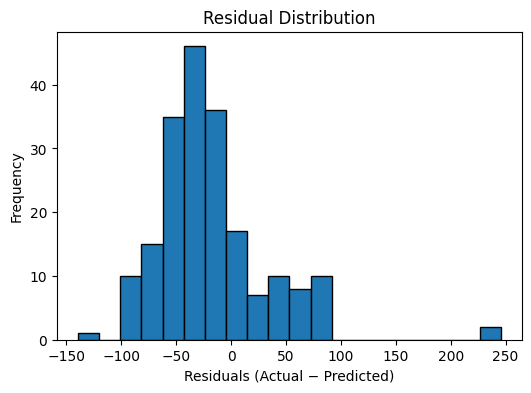

In [57]:
plt.figure(figsize=(6,4))
plt.hist(y_test - y_pred, bins=20, edgecolor='black')
plt.xlabel("Residuals (Actual − Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

Sample predictions for in-progress projects (Random Forest):


,Identifier,District,PlannedDuration,Budget,EstimatedCost,ActualCost,PC1,PC2,PC3,PC4,PredictedActualDuration_SVR,PredictedActualDuration_XGB,PredictedActualDuration_RF
0,KBDD,23,160,60930,3995,3995,0.738653,0.476695,0.465872,0.862702,147.805685,103.313896,122.957051
1,KAYT,23,155,64283,41240,36872,1.985520,0.090806,0.667018,0.974323,150.351263,186.382324,191.740100
2,K411,21,163,52748,49376,8364,8.918068,0.195586,0.176593,1.336228,149.779677,178.458328,175.380630
3,Q090,27,169,102190,146069,145944,-17.758897,1.202303,-0.115135,-2.506692,160.301816,205.414139,184.594460
4,X655,7,163,188750,284485,246758,-6.085039,0.222881,0.222080,0.459376,168.273067,191.049866,207.420707


Saved RF predictions to: d:\Polimi\2nd Semester\PROJECT AND CONSTRUCTION MANAGEMENT\project\construction\24may\Tahvili\inprogress_with_rf_predictions.xlsx

Comparison Metrics between PredictedActualDuration_RF and PlannedDuration:
MSE:   1925.56
MAE:   37.13
MAPE:  22.74%
R²:    -6.415


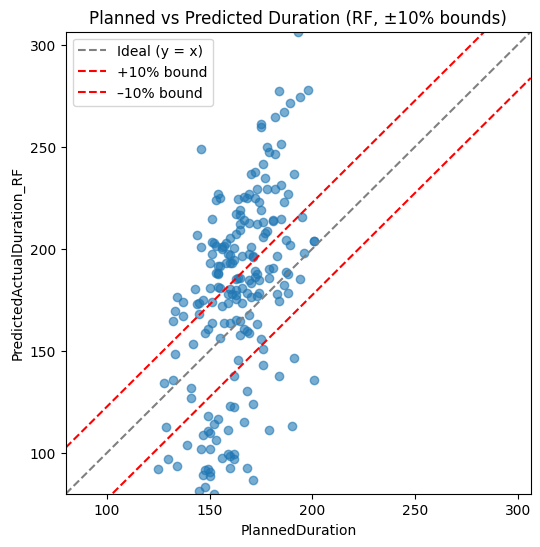

In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# Step 1: Predict ActualDuration for in-progress projects using the best RF model
inprog_preds_rf = best_rf.predict(X_inprog)

# Add predictions to the in-progress dataframe
df_inprogress["PredictedActualDuration_RF"] = inprog_preds_rf

# Show sample predictions
print("Sample predictions for in-progress projects (Random Forest):")
display(df_inprogress.head())

# Step 2: Save to Excel
output_file = "inprogress_with_rf_predictions.xlsx"
df_inprogress.to_excel(output_file, index=False)
print("Saved RF predictions to:", os.path.abspath(output_file))

# Step 3: Compare Predicted vs. Planned durations
planned = df_inprogress["PlannedDuration"]
predicted = df_inprogress["PredictedActualDuration_RF"]

mse   = metrics.mean_squared_error(planned, predicted)
mae   = metrics.mean_absolute_error(planned, predicted)
mape  = np.mean(np.abs((planned - predicted) / planned)) * 100
r2    = metrics.r2_score(planned, predicted)

print("\nComparison Metrics between PredictedActualDuration_RF and PlannedDuration:")
print(f"MSE:   {mse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")
print(f"R²:    {r2:.3f}")

# Step 4: Visualization with ±10% bounds
min_val = min(planned.min(), predicted.min())
max_val = max(planned.max(), predicted.max())
lims    = [min_val, max_val]
delta   = 0.10 * (max_val - min_val)

plt.figure(figsize=(6,6))
plt.scatter(planned, predicted, alpha=0.6)
plt.plot(lims, lims, '--', color='gray', label='Ideal (y = x)')
plt.plot(lims, [l + delta for l in lims], '--', color='red', label='+10% bound')
plt.plot(lims, [l - delta for l in lims], '--', color='red', label='–10% bound')

plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("PlannedDuration")
plt.ylabel("PredictedActualDuration_RF")
plt.title("Planned vs Predicted Duration (RF, ±10% bounds)")
plt.legend()
plt.show()


In [59]:
#------------------catboost

In [60]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from catboost import CatBoostRegressor
from IPython.display import display

# Version checks (optional)
print("pandas:", pd.__version__)
print("numpy: ", np.__version__)
import catboost; print("catboost:", catboost.__version__)

pandas: 2.2.3
numpy:  1.26.4
catboost: 1.2.8


In [61]:
# with grid

In [62]:
# Cell 5: Build CatBoost Pipeline
# (we include a scaler for consistency, though CatBoost can handle raw inputs)
cat_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("cat", CatBoostRegressor(
        verbose=0,
        random_seed=42
    ))
])

In [63]:
# Cell 6: Hyperparameter Tuning via GridSearchCV
param_grid = {
    "cat__iterations":      [100, 300, 500],
    "cat__depth":           [4, 6, 8],
    "cat__learning_rate":   [0.01, 0.1]
}

grid_cat = GridSearchCV(
    cat_pipeline,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid_cat.fit(X_train, y_train)

print("Best params:", grid_cat.best_params_)
print("Best CV MSE:", -grid_cat.best_score_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'cat__depth': 8, 'cat__iterations': 500, 'cat__learning_rate': 0.01}
Best CV MSE: 6271.071744767575


In [64]:
# Cell 7: Evaluate on Validation Set
best_cat = grid_cat.best_estimator_
y_pred   = best_cat.predict(X_test)

mse  = metrics.mean_squared_error( y_test, y_pred )
mae  = metrics.mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2   = metrics.r2_score(y_test, y_pred)

print(f"CatBoost Val MSE:   {mse:.2f}")
print(f"CatBoost Val MAE:   {mae:.2f}")
print(f"CatBoost Val MAPE:  {mape:.2f}%")
print(f"CatBoost Val R²:    {r2:.3f}")

CatBoost Val MSE:   2220.65
CatBoost Val MAE:   34.96
CatBoost Val MAPE:  21.35%
CatBoost Val R²:    -0.536


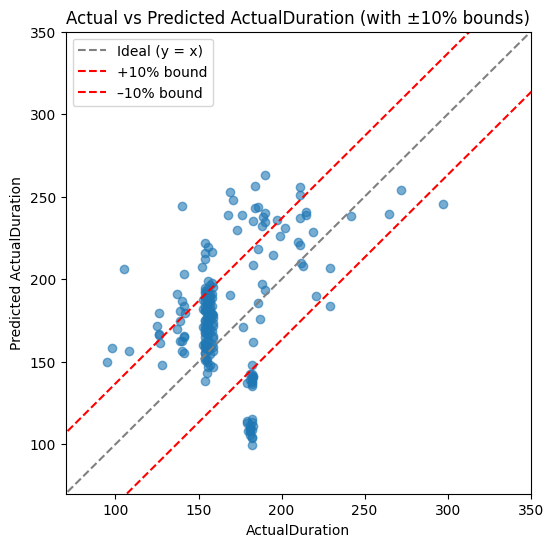

In [65]:
# Step 6: Visualization of results with parallel ±10% bounds
import matplotlib.pyplot as plt

# 6.1 Scatter: Actual vs Predicted
# — your true values are y_test, your predictions are in y_pred
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)

# Determine plotting limits based on the actual durations
min_val = y_test.min()
max_val = y_test.max()
lims    = [min_val, max_val]

# Plot the ideal y = x line
plt.plot(lims, lims, '--', color='gray', label='Ideal (y = x)')

# Compute a constant offset for ±10% of the span
delta = 0.10 * (max_val - min_val)

# Plot parallel ±10% bounds
plt.plot(lims, [l + delta for l in lims], '--', color='red', label='+10% bound')
plt.plot(lims, [l - delta for l in lims], '--', color='red', label='–10% bound')

# Simply set lims yourself:
lims = [70, 350]

plt.xlim(lims)
plt.ylim(lims)


# Set axes, labels, title, legend
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("ActualDuration")
plt.ylabel("Predicted ActualDuration")
plt.title("Actual vs Predicted ActualDuration (with ±10% bounds)")
plt.legend()
plt.show()


In [66]:
# Step 7: Count how many predictions fall within ±10% of actual

# Re-compute the span limits from your test set
min_val, max_val = y_test.min(), y_test.max()
lims = [min_val, max_val]

# Compute the constant ±10% offset
delta = 0.10 * (max_val - min_val)

# Build a boolean mask: True if prediction within [actual - delta, actual + delta]
in_band_mask = (y_pred >= y_test - delta) & (y_pred <= y_test + delta)

# Count in-band vs out-of-band
count_in  = in_band_mask.sum()
count_out = len(y_test) - count_in

print(f"Points within ±10% band: {count_in} / {len(y_test)}")
print(f"Points outside ±10% band: {count_out} / {len(y_test)}")


Points within ±10% band: 119 / 197
Points outside ±10% band: 78 / 197


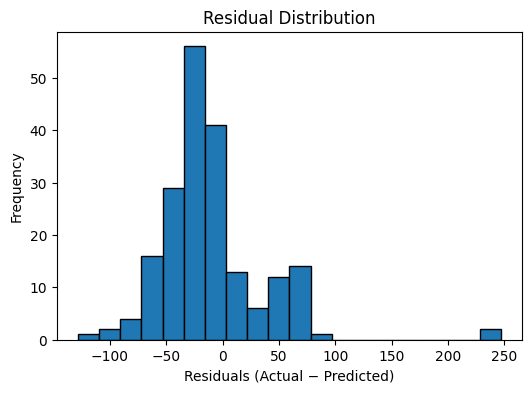

In [67]:
plt.figure(figsize=(6,4))
plt.hist(y_test - y_pred, bins=20, edgecolor='black')
plt.xlabel("Residuals (Actual − Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

Sample predictions for in-progress projects (CatBoost):


,Identifier,District,PlannedDuration,Budget,EstimatedCost,ActualCost,PC1,PC2,PC3,PC4,PredictedActualDuration_SVR,PredictedActualDuration_XGB,PredictedActualDuration_RF,PredictedActualDuration_CatBoost
0,KBDD,23,160,60930,3995,3995,0.738653,0.476695,0.465872,0.862702,147.805685,103.313896,122.957051,152.095409
1,KAYT,23,155,64283,41240,36872,1.985520,0.090806,0.667018,0.974323,150.351263,186.382324,191.740100,182.176762
2,K411,21,163,52748,49376,8364,8.918068,0.195586,0.176593,1.336228,149.779677,178.458328,175.380630,174.192528
3,Q090,27,169,102190,146069,145944,-17.758897,1.202303,-0.115135,-2.506692,160.301816,205.414139,184.594460,176.716393
4,X655,7,163,188750,284485,246758,-6.085039,0.222881,0.222080,0.459376,168.273067,191.049866,207.420707,205.512764


Saved CatBoost predictions to: d:\Polimi\2nd Semester\PROJECT AND CONSTRUCTION MANAGEMENT\project\construction\24may\Tahvili\inprogress_with_catboost_predictions.xlsx

Comparison Metrics between PredictedActualDuration_CatBoost and PlannedDuration:
MSE:   1223.30
MAE:   27.36
MAPE:  16.55%
R²:    -3.710


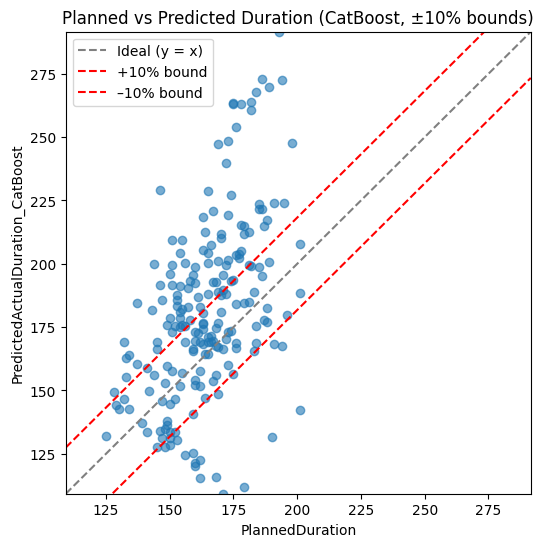

In [68]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# Step 1: Predict ActualDuration for in-progress projects using the best CatBoost model
inprog_preds_cat = best_cat.predict(X_inprog)

# Add predictions to the in-progress dataframe
df_inprogress["PredictedActualDuration_CatBoost"] = inprog_preds_cat

# Show sample predictions
print("Sample predictions for in-progress projects (CatBoost):")
display(df_inprogress.head())

# Step 2: Save to Excel
output_file = "inprogress_with_catboost_predictions.xlsx"
df_inprogress.to_excel(output_file, index=False)
print("Saved CatBoost predictions to:", os.path.abspath(output_file))

# Step 3: Compare Predicted vs. Planned durations
planned   = df_inprogress["PlannedDuration"]
predicted = df_inprogress["PredictedActualDuration_CatBoost"]

mse   = metrics.mean_squared_error(planned, predicted)
mae   = metrics.mean_absolute_error(planned, predicted)
mape  = np.mean(np.abs((planned - predicted) / planned)) * 100
r2    = metrics.r2_score(planned, predicted)

print("\nComparison Metrics between PredictedActualDuration_CatBoost and PlannedDuration:")
print(f"MSE:   {mse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")
print(f"R²:    {r2:.3f}")

# Step 4: Visualization with ±10% bounds
min_val = min(planned.min(), predicted.min())
max_val = max(planned.max(), predicted.max())
lims    = [min_val, max_val]
delta   = 0.10 * (max_val - min_val)

plt.figure(figsize=(6,6))
plt.scatter(planned, predicted, alpha=0.6)
plt.plot(lims, lims, '--', color='gray', label='Ideal (y = x)')
plt.plot(lims, [l + delta for l in lims], '--', color='red', label='+10% bound')
plt.plot(lims, [l - delta for l in lims], '--', color='red', label='–10% bound')

plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("PlannedDuration")
plt.ylabel("PredictedActualDuration_CatBoost")
plt.title("Planned vs Predicted Duration (CatBoost, ±10% bounds)")
plt.legend()
plt.show()


In [69]:
#light GBM

In [70]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from lightgbm import LGBMRegressor
from IPython.display import display

# Version checks (optional)
print("pandas:", pd.__version__)
print("numpy: ", np.__version__)
import lightgbm; print("lightgbm:", lightgbm.__version__)


pandas: 2.2.3
numpy:  1.26.4
lightgbm: 4.6.0


In [71]:
#without scaling

In [72]:
from lightgbm import LGBMRegressor

# Instantiate LightGBM regressor directly (no scaling)
lgbm = LGBMRegressor(random_state=42)

# Fit on raw training data
lgbm.fit(X_train, y_train)

# Predict on raw test data
y_pred = lgbm.predict(X_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1704
[LightGBM] [Info] Number of data points in the train set: 787, number of used features: 9
[LightGBM] [Info] Start training from score 172.952986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [73]:
y_pred = lgbm.predict(X_test)

mse  = metrics.mean_squared_error( y_test, y_pred )
mae  = metrics.mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2   = metrics.r2_score(y_test, y_pred)

print(f"LightGBM Val MSE:   {mse:.2f}")
print(f"LightGBM Val MAE:   {mae:.2f}")
print(f"LightGBM Val MAPE:  {mape:.2f}%")
print(f"LightGBM Val R²:    {r2:.3f}")

LightGBM Val MSE:   3482.00
LightGBM Val MAE:   46.09
LightGBM Val MAPE:  28.29%
LightGBM Val R²:    -1.409


In [74]:
#with scaling

In [75]:
# Cell 5: Build LightGBM Pipeline
lgbm_pipeline = Pipeline([
    ("scaler", StandardScaler()),  
    ("lgbm", LGBMRegressor(random_state=42))
])


In [76]:
#with grid search

In [77]:
# Cell 6: Hyperparameter Tuning via GridSearchCV
param_grid = {
    "lgbm__n_estimators": [100, 300, 500],
    "lgbm__max_depth":    [3, 5, 7],
    "lgbm__learning_rate":[0.01, 0.1]
}

grid_lgbm = GridSearchCV(
    lgbm_pipeline,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid_lgbm.fit(X_train, y_train)

print("Best params:", grid_lgbm.best_params_)
print("Best CV MSE:", -grid_lgbm.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1713
[LightGBM] [Info] Number of data points in the train set: 787, number of used features: 9
[LightGBM] [Info] Start training from score 172.952986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [79]:
# Cell 7: Evaluate on Validation Set
best_lgbm = grid_lgbm.best_estimator_
y_pred    = best_lgbm.predict(X_test)

mse  = metrics.mean_squared_error( y_test, y_pred )
mae  = metrics.mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2   = metrics.r2_score(y_test, y_pred)

print(f"LightGBM Val MSE:   {mse:.2f}")
print(f"LightGBM Val MAE:   {mae:.2f}")
print(f"LightGBM Val MAPE:  {mape:.2f}%")
print(f"LightGBM Val R²:    {r2:.3f}")


LightGBM Val MSE:   2036.97
LightGBM Val MAE:   32.36
LightGBM Val MAPE:  19.78%
LightGBM Val R²:    -0.409


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


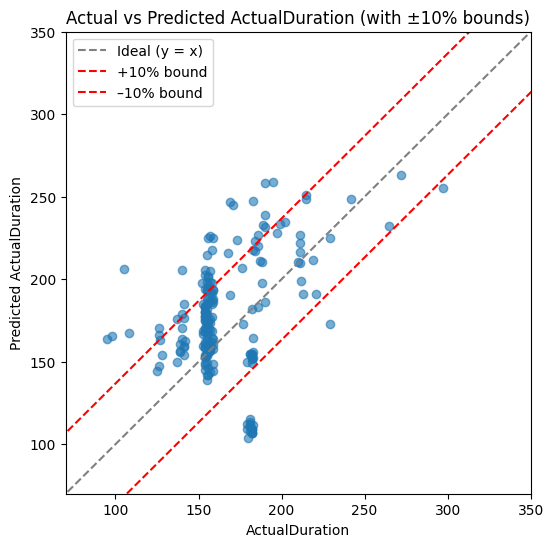

In [80]:
# Step 6: Visualization of results with parallel ±10% bounds
import matplotlib.pyplot as plt

# 6.1 Scatter: Actual vs Predicted
# — your true values are y_test, your predictions are in y_pred
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)

# Determine plotting limits based on the actual durations
min_val = y_test.min()
max_val = y_test.max()
lims    = [min_val, max_val]

# Plot the ideal y = x line
plt.plot(lims, lims, '--', color='gray', label='Ideal (y = x)')

# Compute a constant offset for ±10% of the span
delta = 0.10 * (max_val - min_val)

# Plot parallel ±10% bounds
plt.plot(lims, [l + delta for l in lims], '--', color='red', label='+10% bound')
plt.plot(lims, [l - delta for l in lims], '--', color='red', label='–10% bound')

# Simply set lims yourself:
lims = [70, 350]

plt.xlim(lims)
plt.ylim(lims)


# Set axes, labels, title, legend
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("ActualDuration")
plt.ylabel("Predicted ActualDuration")
plt.title("Actual vs Predicted ActualDuration (with ±10% bounds)")
plt.legend()
plt.show()


In [81]:
# Step 7: Count how many predictions fall within ±10% of actual

# Re-compute the span limits from your test set
min_val, max_val = y_test.min(), y_test.max()
lims = [min_val, max_val]

# Compute the constant ±10% offset
delta = 0.10 * (max_val - min_val)

# Build a boolean mask: True if prediction within [actual - delta, actual + delta]
in_band_mask = (y_pred >= y_test - delta) & (y_pred <= y_test + delta)

# Count in-band vs out-of-band
count_in  = in_band_mask.sum()
count_out = len(y_test) - count_in

print(f"Points within ±10% band: {count_in} / {len(y_test)}")
print(f"Points outside ±10% band: {count_out} / {len(y_test)}")

Points within ±10% band: 136 / 197
Points outside ±10% band: 61 / 197


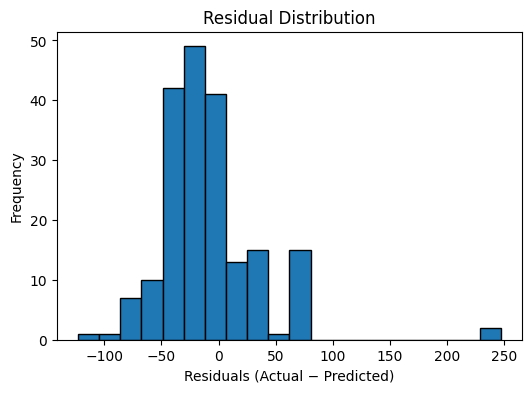

In [82]:
plt.figure(figsize=(6,4))
plt.hist(y_test - y_pred, bins=20, edgecolor='black')
plt.xlabel("Residuals (Actual − Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

Sample predictions for in-progress projects (LightGBM):


,Identifier,District,PlannedDuration,Budget,EstimatedCost,ActualCost,PC1,PC2,PC3,PC4,PredictedActualDuration_SVR,PredictedActualDuration_XGB,PredictedActualDuration_RF,PredictedActualDuration_CatBoost,PredictedActualDuration_LightGBM
0,KBDD,23,160,60930,3995,3995,0.738653,0.476695,0.465872,0.862702,147.805685,103.313896,122.957051,152.095409,111.231524
1,KAYT,23,155,64283,41240,36872,1.985520,0.090806,0.667018,0.974323,150.351263,186.382324,191.740100,182.176762,196.883963
2,K411,21,163,52748,49376,8364,8.918068,0.195586,0.176593,1.336228,149.779677,178.458328,175.380630,174.192528,216.014474
3,Q090,27,169,102190,146069,145944,-17.758897,1.202303,-0.115135,-2.506692,160.301816,205.414139,184.594460,176.716393,197.620141
4,X655,7,163,188750,284485,246758,-6.085039,0.222881,0.222080,0.459376,168.273067,191.049866,207.420707,205.512764,235.339233


Saved LightGBM predictions to: d:\Polimi\2nd Semester\PROJECT AND CONSTRUCTION MANAGEMENT\project\construction\24may\Tahvili\inprogress_with_lightgbm_predictions.xlsx

Comparison Metrics between PredictedActualDuration_LightGBM and PlannedDuration:
MSE:   3061.56
MAE:   46.21
MAPE:  28.28%
R²:    -10.789


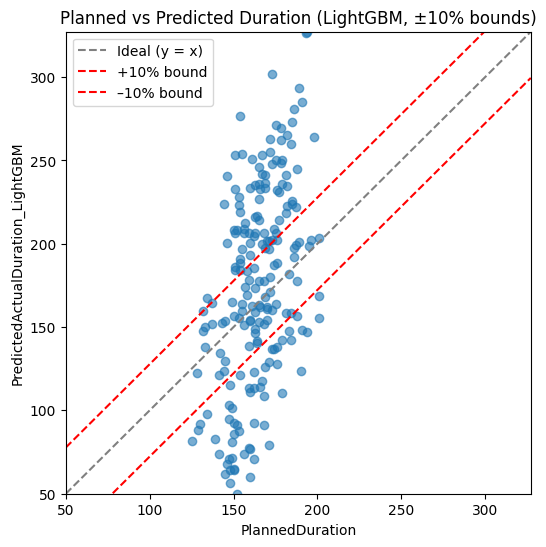

In [84]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# Step 1: Predict ActualDuration for in-progress projects using the trained LightGBM model
inprog_preds_lgbm = lgbm.predict(X_inprog)


# Add predictions to the in-progress dataframe
df_inprogress["PredictedActualDuration_LightGBM"] = inprog_preds_lgbm

# Show sample predictions
print("Sample predictions for in-progress projects (LightGBM):")
display(df_inprogress.head())

# Step 2: Save to Excel
output_file = "inprogress_with_lightgbm_predictions.xlsx"
df_inprogress.to_excel(output_file, index=False)
print("Saved LightGBM predictions to:", os.path.abspath(output_file))

# Step 3: Compare Predicted vs. Planned durations
planned   = df_inprogress["PlannedDuration"]
predicted = df_inprog_preds_lgbm = df_inprogress["PredictedActualDuration_LightGBM"]

mse   = metrics.mean_squared_error(planned, predicted)
mae   = metrics.mean_absolute_error(planned, predicted)
mape  = np.mean(np.abs((planned - predicted) / planned)) * 100
r2    = metrics.r2_score(planned, predicted)

print("\nComparison Metrics between PredictedActualDuration_LightGBM and PlannedDuration:")
print(f"MSE:   {mse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")
print(f"R²:    {r2:.3f}")

# Step 4: Visualization with ±10% bounds
min_val = min(planned.min(), predicted.min())
max_val = max(planned.max(), predicted.max())
lims    = [min_val, max_val]
delta   = 0.10 * (max_val - min_val)

plt.figure(figsize=(6,6))
plt.scatter(planned, predicted, alpha=0.6)
plt.plot(lims, lims, '--', color='gray', label='Ideal (y = x)')
plt.plot(lims, [l + delta for l in lims], '--', color='red', label='+10% bound')
plt.plot(lims, [l - delta for l in lims], '--', color='red', label='–10% bound')

plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("PlannedDuration")
plt.ylabel("PredictedActualDuration_LightGBM")
plt.title("Planned vs Predicted Duration (LightGBM, ±10% bounds)")
plt.legend()
plt.show()


In [ ]:
#-------------autoML

In [85]:
# Cell 1: Install and Import Libraries
# Uncomment to install TPOT if needed:
# !pip install tpot

import pandas as pd
import numpy as np
import os

from tpot import TPOTRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from IPython.display import display

print("pandas:", pd.__version__)
print("numpy: ", np.__version__)
import tpot; print("TPOT:", tpot.__version__)


pandas: 2.2.3
numpy:  1.26.4
TPOT: 0.12.2


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [86]:
# Cell 5: Scale Features
scaler = StandardScaler()
X_train_scaled  = scaler.fit_transform(X_train)
X_test_scaled   = scaler.transform(X_test)
X_all_scaled    = scaler.fit_transform(X_completed)
X_inprog_scaled = scaler.transform(X_inprog)

In [87]:
# Cell 6: Run TPOT AutoML
tpot_est = TPOTRegressor(
    generations=5,
    population_size=50,
    verbosity=2,
    random_state=42,
    scoring='neg_mean_squared_error',
    cv=5,
    max_time_mins=10
)
tpot_est.fit(X_train_scaled, y_train)

print("Best pipeline:", tpot_est.fitted_pipeline_)
print("Validation score (neg MSE):", tpot_est.score(X_test_scaled, y_test))


is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1270: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor


Version 0.12.2 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


                                                                              
Generation 1 - Current best internal CV score: -6477.695064193716
                                                                              
Generation 2 - Current best internal CV score: -6406.852914555757
                                                                              
Generation 3 - Current best internal CV score: -6406.852914555757
                                                                              
                                                                              
TPOT closed during evaluation in one generation.
                                                                              
                                                                              
TPOT closed prematurely. Will use the current best pipeline.
                                                                              
Best pipeline: ExtraTreesRegressor(DecisionTreeRegressor(inp

In [88]:
# Cell 7: Evaluate on Validation Set
y_pred = tpot_est.predict(X_test_scaled)
mse  = metrics.mean_squared_error(y_test, y_pred)
mae  = metrics.mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2   = metrics.r2_score(y_test, y_pred)

print(f"Val MSE:  {mse:.2f}")
print(f"Val MAE:  {mae:.2f}")
print(f"Val MAPE: {mape:.2f}%")
print(f"Val R²:   {r2:.3f}")

Val MSE:  2581.00
Val MAE:  41.06
Val MAPE: 25.46%
Val R²:   -0.786


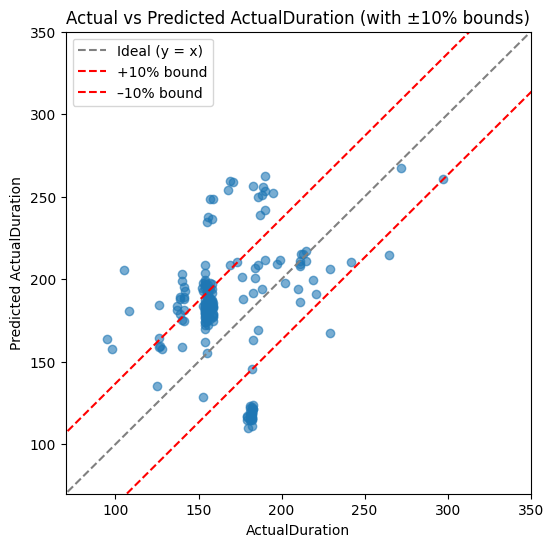

In [89]:
# Step 6: Visualization of results with parallel ±10% bounds
import matplotlib.pyplot as plt

# 6.1 Scatter: Actual vs Predicted
# — your true values are y_test, your predictions are in y_pred
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)

# Determine plotting limits based on the actual durations
min_val = y_test.min()
max_val = y_test.max()
lims    = [min_val, max_val]

# Plot the ideal y = x line
plt.plot(lims, lims, '--', color='gray', label='Ideal (y = x)')

# Compute a constant offset for ±10% of the span
delta = 0.10 * (max_val - min_val)

# Plot parallel ±10% bounds
plt.plot(lims, [l + delta for l in lims], '--', color='red', label='+10% bound')
plt.plot(lims, [l - delta for l in lims], '--', color='red', label='–10% bound')

# Simply set lims yourself:
lims = [70, 350]

plt.xlim(lims)
plt.ylim(lims)


# Set axes, labels, title, legend
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("ActualDuration")
plt.ylabel("Predicted ActualDuration")
plt.title("Actual vs Predicted ActualDuration (with ±10% bounds)")
plt.legend()
plt.show()


In [ ]:
# Step 7: Count how many predictions fall within ±10% of actual

# Re-compute the span limits from your test set
min_val, max_val = y_test.min(), y_test.max()
lims = [min_val, max_val]

# Compute the constant ±10% offset
delta = 0.10 * (max_val - min_val)

# Build a boolean mask: True if prediction within [actual - delta, actual + delta]
in_band_mask = (y_pred >= y_test - delta) & (y_pred <= y_test + delta)

# Count in-band vs out-of-band
count_in  = in_band_mask.sum()
count_out = len(y_test) - count_in

print(f"Points within ±10% band: {count_in} / {len(y_test)}")
print(f"Points outside ±10% band: {count_out} / {len(y_test)}")

Points within ±10% band: 109 / 197
Points outside ±10% band: 88 / 197


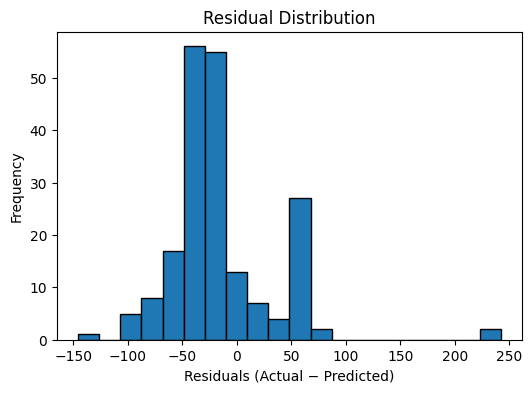

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(y_test - y_pred, bins=20, edgecolor='black')
plt.xlabel("Residuals (Actual − Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

Sample predictions for in-progress projects (AutoML):


,Identifier,District,PlannedDuration,Budget,EstimatedCost,ActualCost,PC1,PC2,PC3,PC4,PredictedActualDuration_SVR,PredictedActualDuration_XGB,PredictedActualDuration_RF,PredictedActualDuration_CatBoost,PredictedActualDuration_LightGBM,PredictedActualDuration_AutoML
0,KBDD,23,160,60930,3995,3995,0.738653,0.476695,0.465872,0.862702,147.805685,103.313896,122.957051,152.095409,111.231524,191.821660
1,KAYT,23,155,64283,41240,36872,1.985520,0.090806,0.667018,0.974323,150.351263,186.382324,191.740100,182.176762,196.883963,197.829756
2,K411,21,163,52748,49376,8364,8.918068,0.195586,0.176593,1.336228,149.779677,178.458328,175.380630,174.192528,216.014474,199.662915
3,Q090,27,169,102190,146069,145944,-17.758897,1.202303,-0.115135,-2.506692,160.301816,205.414139,184.594460,176.716393,197.620141,174.080389
4,X655,7,163,188750,284485,246758,-6.085039,0.222881,0.222080,0.459376,168.273067,191.049866,207.420707,205.512764,235.339233,212.932108


Saved AutoML predictions to: d:\Polimi\2nd Semester\PROJECT AND CONSTRUCTION MANAGEMENT\project\construction\24may\Tahvili\inprogress_with_automl_predictions.xlsx

Comparison Metrics between PredictedActualDuration_AutoML and PlannedDuration:
MSE:   1562.28
MAE:   31.49
MAPE:  19.19%
R²:    -5.016


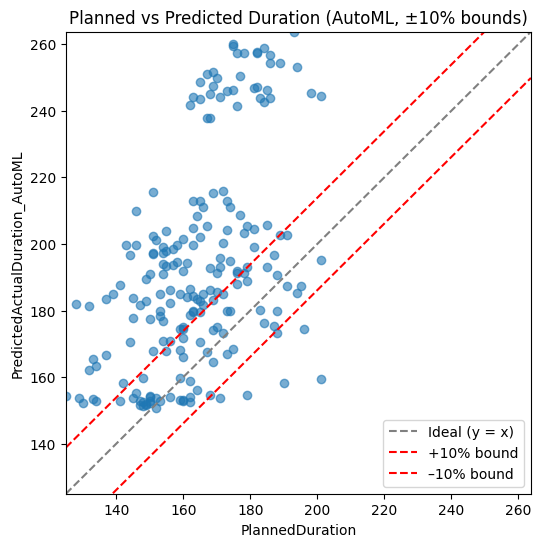

In [90]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# Step 1: Predict ActualDuration for in-progress projects using the TPOT AutoML pipeline
# Note: TPOT’s pipeline expects scaled input since you trained on X_train_scaled
inprog_preds_automl = tpot_est.predict(X_inprog_scaled)

# Add predictions to the in-progress dataframe
df_inprogress["PredictedActualDuration_AutoML"] = inprog_preds_automl

# Show a sample of the dataframe with the new predictions
print("Sample predictions for in-progress projects (AutoML):")
display(df_inprogress.head())

# Step 2: Save to Excel
output_file = "inprogress_with_automl_predictions.xlsx"
df_inprogress.to_excel(output_file, index=False)
print("Saved AutoML predictions to:", os.path.abspath(output_file))

# Step 3: Compare Predicted vs. Planned durations
planned   = df_inprogress["PlannedDuration"]
predicted = df_inprogress["PredictedActualDuration_AutoML"]

mse   = metrics.mean_squared_error(planned, predicted)
mae   = metrics.mean_absolute_error(planned, predicted)
mape  = np.mean(np.abs((planned - predicted) / planned)) * 100
RSS   = np.sum((planned - predicted) ** 2)
TSS   = np.sum((planned - np.mean(planned)) ** 2)
r2    = 1 - RSS / TSS

print("\nComparison Metrics between PredictedActualDuration_AutoML and PlannedDuration:")
print(f"MSE:   {mse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")
print(f"R²:    {r2:.3f}")

# Step 4: Visualization with ±10% bounds
min_val = min(planned.min(), predicted.min())
max_val = max(planned.max(), predicted.max())
lims    = [min_val, max_val]
delta   = 0.10 * (max_val - min_val)

plt.figure(figsize=(6,6))
plt.scatter(planned, predicted, alpha=0.6)
plt.plot(lims, lims, '--', color='gray', label='Ideal (y = x)')
plt.plot(lims, [l + delta for l in lims], '--', color='red', label='+10% bound')
plt.plot(lims, [l - delta for l in lims], '--', color='red', label='–10% bound')

plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("PlannedDuration")
plt.ylabel("PredictedActualDuration_AutoML")
plt.title("Planned vs Predicted Duration (AutoML, ±10% bounds)")
plt.legend()
plt.show()


In [91]:
#------------Neural Network--------

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [8]:
# Define features and target columns
feature_cols = ['PC1', 'PC2', 'PC3', 'PC4', 'ActualCost', 'EstimatedCost', 'Budget', 'PlannedDuration', 'District']
target_col = 'ActualDuration'

# Extract features and target from completed dataset
X = df_completed[feature_cols].values
y = df_completed[target_col].values

# Extract features from in-progress dataset
X_inprog = df_inprogress[feature_cols].values

# Split into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_inprog_scaled = scaler.transform(X_inprog)


In [9]:
# Define a simple feed-forward neural network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 34529.2148 - mae: 169.1880 - val_loss: 38921.4258 - val_mae: 179.5727
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36138.5078 - mae: 170.7464 - val_loss: 37935.3281 - val_mae: 176.8880
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34585.5156 - mae: 166.5118 - val_loss: 36199.8789 - val_mae: 171.9090
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31366.1035 - mae: 159.7792 - val_loss: 33471.5898 - val_mae: 163.3399
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28538.3105 - mae: 151.2070 - val_loss: 29769.1133 - val_mae: 151.6229
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25584.1699 - mae: 140.2835 - val_loss: 25886.9883 - val_mae: 138.2331
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19871.3867 - mae: 120.4564 - val_loss: 22854.0156 - val_mae: 121.2685
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16307.3857 - mae: 100.8624 - val_loss:

In [11]:
# Predict on validation set
y_val_pred = model.predict(X_val_scaled).flatten()

# Calculate metrics
mse  = metrics.mean_squared_error(y_val, y_val_pred)
mae  = metrics.mean_absolute_error(y_val, y_val_pred)
mape = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
r2   = metrics.r2_score(y_val, y_val_pred)

print(f"MSE:   {mse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")
print(f"R²:    {r2:.3f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE:   7004.89
MAE:   56.66
MAPE:  35.01%
R²:    -0.045


In [12]:
# Step 0: Imports (make sure all are present)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn import metrics
import pandas as pd

from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers  import Dense

# (Re)define features and target
feature_cols = ['PC1','PC2','PC3','PC4','ActualCost','EstimatedCost','Budget','PlannedDuration','District']
target_col  = 'ActualDuration'

X           = df_completed[feature_cols].values
y           = df_completed[target_col].values
X_inprog    = df_inprogress[feature_cols].values

# 80/20 random split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Scale
scaler = StandardScaler()
X_train_scaled  = scaler.fit_transform(X_train)
X_val_scaled    = scaler.transform(X_val)
X_inprog_scaled = scaler.transform(X_inprog)

# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Predict & evaluate
y_val_pred = model.predict(X_val_scaled).flatten()

mse  = metrics.mean_squared_error(y_val, y_val_pred)
mae  = metrics.mean_absolute_error(y_val, y_val_pred)
mape = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
r2   = metrics.r2_score(y_val, y_val_pred)

print(f"MSE:   {mse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")
print(f"R²:    {r2:.3f}")


Epoch 1/100


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 34182.1680 - mae: 168.2760 - val_loss: 39198.9922 - val_mae: 180.2481
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35146.2969 - mae: 169.3500 - val_loss: 38535.7656 - val_mae: 178.4110
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34254.0742 - mae: 167.1704 - val_loss: 37414.9961 - val_mae: 175.2572
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32344.3320 - mae: 160.1284 - val_loss: 35517.1484 - val_mae: 169.7460
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30558.2109 - mae: 157.6765 - val_loss: 32571.8887 - val_mae: 160.6008
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26027.0430 - mae: 143.3604 - val_loss: 28676.7891 - val_mae: 147.5374
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24518.3125 - mae: 135.5317 - val_loss: 24370.3984 - val_mae: 132.8949
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20354.9180 - mae: 118.7176 - val_loss: 20782.3281 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Sample predictions for in-progress projects (Neural Network):


,Identifier,District,PlannedDuration,Budget,EstimatedCost,ActualCost,PC1,PC2,PC3,PC4,PredictedActualDuration_NN
0,KBDD,23,160,60930,3995,3995,0.738653,0.476695,0.465872,0.862702,129.760712
1,KAYT,23,155,64283,41240,36872,1.985520,0.090806,0.667018,0.974323,137.378387
2,K411,21,163,52748,49376,8364,8.918068,0.195586,0.176593,1.336228,130.301117
3,Q090,27,169,102190,146069,145944,-17.758897,1.202303,-0.115135,-2.506692,162.322372
4,X655,7,163,188750,284485,246758,-6.085039,0.222881,0.222080,0.459376,165.301559


Saved NN predictions to: d:\Polimi\2nd Semester\PROJECT AND CONSTRUCTION MANAGEMENT\project\construction\24may\Tahvili\inprogress_with_nn_predictions.xlsx

Comparison Metrics between PredictedActualDuration_NN and PlannedDuration:
MSE:   1633.62
MAE:   27.67
MAPE:  16.67%
R²:    -5.290


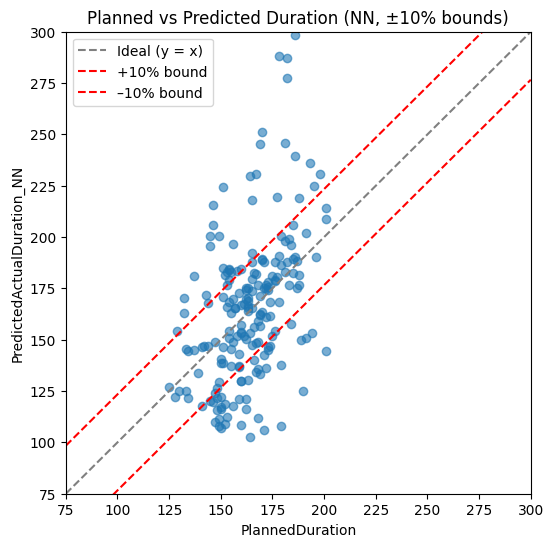

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# Step 1: Predict ActualDuration for in-progress projects using the trained neural network
inprog_preds_nn = model.predict(X_inprog_scaled).flatten()

# Add predictions to the in-progress dataframe
df_inprogress["PredictedActualDuration_NN"] = inprog_preds_nn

# Show a sample of the dataframe with the new predictions
print("Sample predictions for in-progress projects (Neural Network):")
display(df_inprogress.head())

# Step 2: Save to Excel
output_file = "inprogress_with_nn_predictions.xlsx"
df_inprogress.to_excel(output_file, index=False)
print("Saved NN predictions to:", os.path.abspath(output_file))

# Step 3: Compare Predicted vs. Planned durations
planned   = df_inprogress["PlannedDuration"]
predicted = df_inprogress["PredictedActualDuration_NN"]

mse   = metrics.mean_squared_error(planned, predicted)
mae   = metrics.mean_absolute_error(planned, predicted)
mape  = np.mean(np.abs((planned - predicted) / planned)) * 100
r2    = metrics.r2_score(planned, predicted)

print("\nComparison Metrics between PredictedActualDuration_NN and PlannedDuration:")
print(f"MSE:   {mse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")
print(f"R²:    {r2:.3f}")

# Step 4: Visualization with ±10% bounds
min_val = min(planned.min(), predicted.min())
max_val = max(planned.max(), predicted.max())
lims    = [min_val, max_val]
delta   = 0.10 * (max_val - min_val)

# Simply set lims yourself:
lims = [75, 300]

plt.figure(figsize=(6,6))
plt.scatter(planned, predicted, alpha=0.6)
plt.plot(lims, lims, '--', color='gray', label='Ideal (y = x)')
plt.plot(lims, [l + delta for l in lims], '--', color='red', label='+10% bound')
plt.plot(lims, [l - delta for l in lims], '--', color='red', label='–10% bound')

plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("PlannedDuration")
plt.ylabel("PredictedActualDuration_NN")
plt.title("Planned vs Predicted Duration (NN, ±10% bounds)")
plt.legend()
plt.show()


In [100]:
#------------Linear Regression

In [15]:
# cell 1: Imports & data load
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Load completed and in-progress data
df_completed  = pd.read_excel("completed.xlsx")
df_inprogress = pd.read_excel("inprogress.xlsx")

print("Completed:", df_completed.shape)
print("In-progress:", df_inprogress.shape)


Completed: (984, 11)
In-progress: (201, 10)


In [16]:
# cell 2: Feature/target setup
feature_cols = [
    "PC1","PC2","PC3","PC4",  # description PCs
    "ActualCost",             # actual cost
    "EstimatedCost",          # estimated cost
    "Budget",                 # budget
    "PlannedDuration",        # planned duration
    "District"                # district
]

X_completed = df_completed[feature_cols]
y_completed = df_completed["ActualDuration"]

X_inprog = df_inprogress[feature_cols]

print("X_completed shape:", X_completed.shape)
print("y_completed shape:", y_completed.shape)
print("X_inprog shape:", X_inprog.shape)


X_completed shape: (984, 9)
y_completed shape: (984,)
X_inprog shape: (201, 9)


In [17]:
# cell 3: Custom train/validation split (every 5th for validation)
n = len(df_completed)
test_idx  = list(range(2, n, 5))           
train_idx = [i for i in range(n) if i not in test_idx]

X_train = X_completed.iloc[train_idx]
y_train = y_completed.iloc[train_idx]
X_test  = X_completed.iloc[test_idx]
y_test  = y_completed.iloc[test_idx]

print(f"Train: {X_train.shape[0]} rows, Test: {X_test.shape[0]} rows")
print("Validation sample identifiers:")
display(df_completed.loc[test_idx, ["Identifier"]].head())


Train: 787 rows, Test: 197 rows
Validation sample identifiers:


,Identifier
2,KBDA
7,KBRV
12,R019
17,K257
22,R128


In [18]:
# cell 4: Pipeline definition
pipeline = Pipeline([
    ("scaler", StandardScaler()),  
    ("lr",    LinearRegression())
])


In [19]:
# cell 5: Train Linear Regression
pipeline.fit(X_train, y_train)
print(f"LinearRegression trained on {X_train.shape[0]} samples.")


LinearRegression trained on 787 samples.


In [20]:
# cell 6: Predict & compute validation metrics
y_pred = pipeline.predict(X_test)

mse   = metrics.mean_squared_error(y_test, y_pred)
msep  = np.mean((y_test - y_pred)**2 / (y_test**2)) * 100
mae   = metrics.mean_absolute_error(y_test, y_pred)
mape  = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# R² via RSS/TSS for consistency with your SVR code
RSS = np.sum((y_test - y_pred)**2)
TSS = np.sum((y_test - np.mean(y_test))**2)
r2    = 1 - RSS/TSS

print(f"MSE:   {mse:.2f}")
print(f"MSEP:  {msep:.2f}%")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")
print(f"R²:    {r2:.3f}")


MSE:   6383.38
MSEP:  20.23%
MAE:   53.59
MAPE:  31.52%
R²:    -3.416


In [21]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Replace the LinearRegression step with Ridge in a pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

# Define a grid of alpha (regularization strength) to search over
param_grid = {
    "ridge__alpha": [0.01, 0.1, 1, 10, 100]
}

# Grid search with 5-fold CV
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

# Fit on your training split
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_["ridge__alpha"])
print("Best CV MSE:", -grid.best_score_)

# Evaluate on your validation set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse   = mean_squared_error(y_test, y_pred)
mae   = mean_absolute_error(y_test, y_pred)
mape  = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2    = r2_score(y_test, y_pred)

print(f"Val MSE:   {mse:.2f}")
print(f"Val MAE:   {mae:.2f}")
print(f"Val MAPE:  {mape:.2f}%")
print(f"Val R²:    {r2:.3f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best alpha: 100
Best CV MSE: 7474.821105569643
Val MSE:   4581.58
Val MAE:   45.73
Val MAPE:  27.09%
Val R²:    -2.170


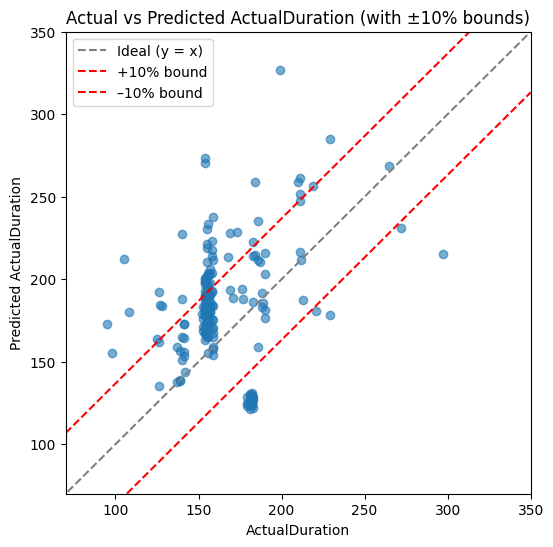

In [22]:
# Visualization of results
import matplotlib.pyplot as plt

# scatter Actual vs Predicted
# true values ==> y_test,  predictions ==> y_pred
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)

# Determine plotting limits based on the actual durations
min_val = y_test.min()
max_val = y_test.max()
lims    = [min_val, max_val]

# Plot the 45 degree line
plt.plot(lims, lims, '--', color='gray', label='Ideal (y = x)')

# Compute a constant offset for ±10% of the span
delta = 0.10 * (max_val - min_val)

# Simply set lims yourself:
lims = [70, 350]

plt.xlim(lims)
plt.ylim(lims)

# Plot parallel ±10% bounds
plt.plot(lims, [l + delta for l in lims], '--', color='red', label='+10% bound')
plt.plot(lims, [l - delta for l in lims], '--', color='red', label='–10% bound')

# Seting axes, labels, title, legend
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("ActualDuration")
plt.ylabel("Predicted ActualDuration")
plt.title("Actual vs Predicted ActualDuration (with ±10% bounds)")
plt.legend()
plt.show()


Sample predictions for in-progress projects:


,Identifier,District,PlannedDuration,Budget,EstimatedCost,ActualCost,PC1,PC2,PC3,PC4,PredictedActualDuration
0,KBDD,23,160,60930,3995,3995,0.738653,0.476695,0.465872,0.862702,164.081818
1,KAYT,23,155,64283,41240,36872,1.985520,0.090806,0.667018,0.974323,165.240013
2,K411,21,163,52748,49376,8364,8.918068,0.195586,0.176593,1.336228,166.873489
3,Q090,27,169,102190,146069,145944,-17.758897,1.202303,-0.115135,-2.506692,148.755802
4,X655,7,163,188750,284485,246758,-6.085039,0.222881,0.222080,0.459376,189.925613


Saved predictions to: d:\Polimi\2nd Semester\PROJECT AND CONSTRUCTION MANAGEMENT\project\construction\24may\Tahvili\inprogress_with_predictions.xlsx

Comparison Metrics between Predicted vs. Planned Duration:
MSE:   853.14
MAE:   24.48
MAPE:  15.16%
R²:    -2.285


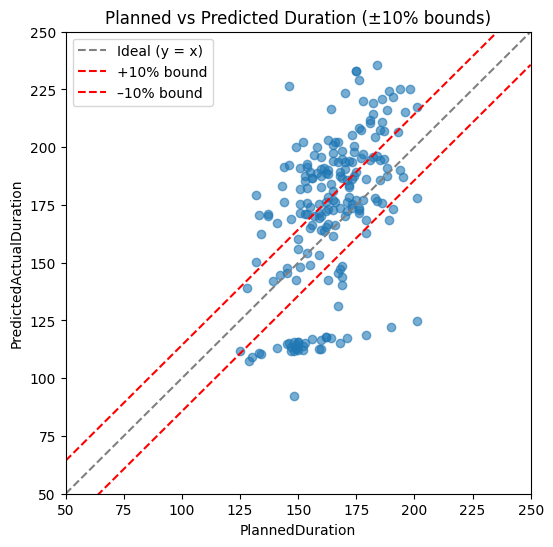

In [24]:
# Step 1: Predict ActualDuration for in-progress projects
inprog_preds = best_model.predict(X_inprog)

# Add predictions to the in-progress dataframe
df_inprogress["PredictedActualDuration"] = inprog_preds

# Show sample predictions
print("Sample predictions for in-progress projects:")
display(df_inprogress.head())

# Step 2: Save to Excel
import os
output_file = "inprogress_with_predictions.xlsx"
df_inprogress.to_excel(output_file, index=False)
print("Saved predictions to:", os.path.abspath(output_file))

# Step 3: Compare Predicted vs. Planned durations
from sklearn import metrics
import numpy as np

planned   = df_inprogress["PlannedDuration"]
predicted = df_inprogress["PredictedActualDuration"]

mse   = metrics.mean_squared_error(planned, predicted)
mae   = metrics.mean_absolute_error(planned, predicted)
mape  = np.mean(np.abs((planned - predicted) / planned)) * 100

# Compute R² via RSS/TSS for consistency
RSS  = np.sum((planned - predicted) ** 2)
TSS  = np.sum((planned - np.mean(planned)) ** 2)
r2   = 1 - RSS / TSS

print("\nComparison Metrics between Predicted vs. Planned Duration:")
print(f"MSE:   {mse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"MAPE:  {mape:.2f}%")
print(f"R²:    {r2:.3f}")

# Step 4: Visualization with ±10% bounds
import matplotlib.pyplot as plt

min_val = min(planned.min(), predicted.min())
max_val = max(planned.max(), predicted.max())
lims    = [min_val, max_val]
delta   = 0.10 * (max_val - min_val)

# Simply set lims yourself:
lims = [50, 250]


plt.figure(figsize=(6,6))
plt.scatter(planned, predicted, alpha=0.6)
plt.plot(lims, lims, '--', color='gray', label='Ideal (y = x)')
plt.plot(lims, [l + delta for l in lims], '--', color='red', label='+10% bound')
plt.plot(lims, [l - delta for l in lims], '--', color='red', label='–10% bound')

plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("PlannedDuration")
plt.ylabel("PredictedActualDuration")
plt.title("Planned vs Predicted Duration (±10% bounds)")
plt.legend()
plt.show()


In [ ]:
#-------------------------************Finish*********-------------